# Breast Cancer Data Set Tumor Type Clasification Task

This dataset originated from the UCI Machine Learning Repository (https://data.world/health/breast-cancer-wisconsin) and was uploaded to serve as a machine learning practice dataset by Nick Street (one of the creators) in November 1995.

Features are computed from a digitized image of breast tissue obtained with fine needle aspirate (FNA) and this tabular dataset created. The features describe the characteristics of the cell nuclei present in the image. The task of this project is to classify whether the tumor is benign (B) or malignant (M).

Dataset retrieved from https://www.kaggle.com/datasets/abhinavmangalore/breast-cancer-dataset-wisconsin-diagnostic-uci on 02/05/2024.

The scientific paper in that dataset first appeared:
W.N. Street, W.H. Wolberg and O.L. Mangasarian
Nuclear feature extraction for breast tumor diagnosis.
IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science
and Technology, volume 1905, pages 861-870, San Jose, CA, 1993.

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# 1. Exploratory Data Analysis (EDA)

In [ ]:
# function to check basic atributes of dataframe as shape, types, head, tail, null values
# and basic statistical features
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Describe #####################")
    print(dataframe.describe())

# summarize categorical features by showing frequency
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
# summarize numerical features with descriptive statistics
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

 # calculate mean of numerical features at diffraction of target
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

# grab features seperately as numerical, categorical and cardinal
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [ ]:
#upload dataset, copy and quickly check
df_= pd.read_csv("/content/drive/MyDrive/breast-cancer-wisconsin-data.csv")
df = df_.copy()

check_df(df)

##################### Shape #####################
(569, 32)
##################### Types #####################
id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst     

In [ ]:
df.duplicated().sum() #check duplicates

0

In [ ]:
# Seperate features
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

# summarize categorical features
for col in cat_cols:
    cat_summary(df, col)

           diagnosis      Ratio
diagnosis                      
B                357  62.741652
M                212  37.258348
##########################################


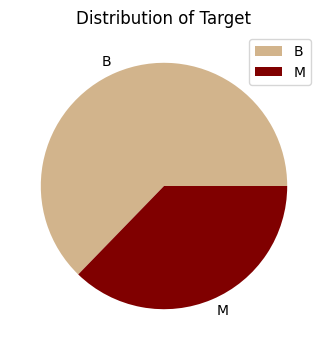

In [ ]:
# create pie chart showing distribution of target
plt.figure(figsize=(6,4))
plt.title("Distribution of Target")
plt.pie([df['diagnosis'].value_counts()[0],df['diagnosis'].value_counts()[1]],colors=['tan','maroon'],
        labels=['B','M'])
plt.legend()
plt.show()



In [ ]:
# describe numerical features
df[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01
symmetry_mean,569.0,1.811619e-01,2.741428e-02,0.106000,0.161900,0.179200,1.957000e-01,3.040000e-01


count    5.690000e+02
mean     3.037183e+07
std      1.250206e+08
min      8.670000e+03
5%       9.026700e+04
10%      8.531554e+05
20%      8.631744e+05
30%      8.755090e+05
40%      8.946068e+05
50%      9.060240e+05
60%      9.158902e+05
70%      8.611965e+06
80%      9.010708e+06
90%      8.814422e+07
95%      9.042446e+07
99%      9.010343e+08
max      9.113205e+08
Name: id, dtype: float64


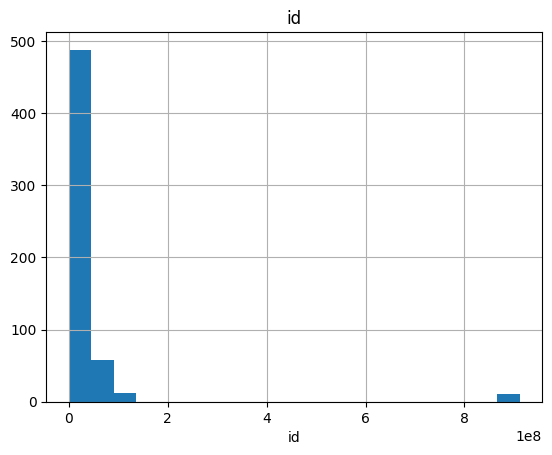

count    569.000000
mean      14.127292
std        3.524049
min        6.981000
5%         9.529200
10%       10.260000
20%       11.366000
30%       12.012000
40%       12.726000
50%       13.370000
60%       14.058000
70%       15.056000
80%       17.068000
90%       19.530000
95%       20.576000
99%       24.371600
max       28.110000
Name: radius_mean, dtype: float64


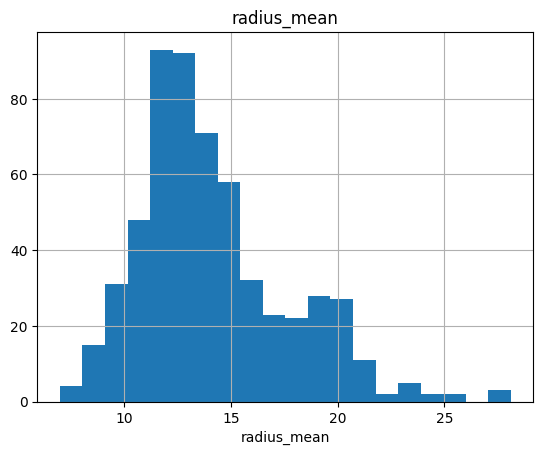

count    569.000000
mean      19.289649
std        4.301036
min        9.710000
5%        13.088000
10%       14.078000
20%       15.656000
30%       16.840000
40%       17.912000
50%       18.840000
60%       19.968000
70%       21.272000
80%       22.440000
90%       24.992000
95%       27.150000
99%       30.652000
max       39.280000
Name: texture_mean, dtype: float64


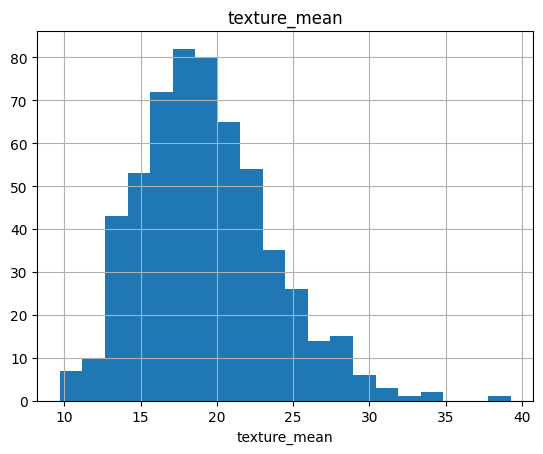

count    569.000000
mean      91.969033
std       24.298981
min       43.790000
5%        60.496000
10%       65.830000
20%       73.292000
30%       77.360000
40%       81.938000
50%       86.240000
60%       91.420000
70%       98.200000
80%      111.680000
90%      129.100000
95%      135.820000
99%      165.724000
max      188.500000
Name: perimeter_mean, dtype: float64


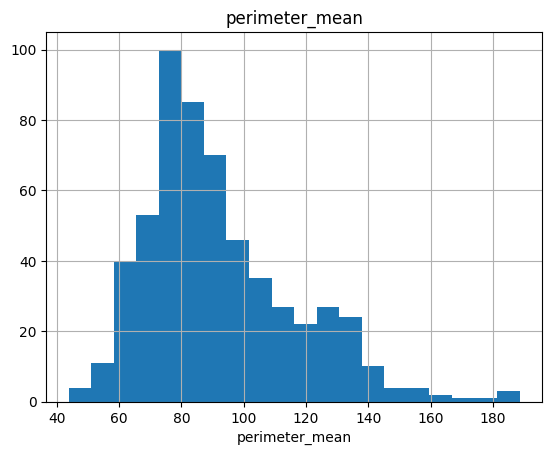

count     569.000000
mean      654.889104
std       351.914129
min       143.500000
5%        275.780000
10%       321.600000
20%       396.560000
30%       444.060000
40%       496.440000
50%       551.100000
60%       609.740000
70%       700.660000
80%       915.060000
90%      1177.400000
95%      1309.800000
99%      1786.600000
max      2501.000000
Name: area_mean, dtype: float64


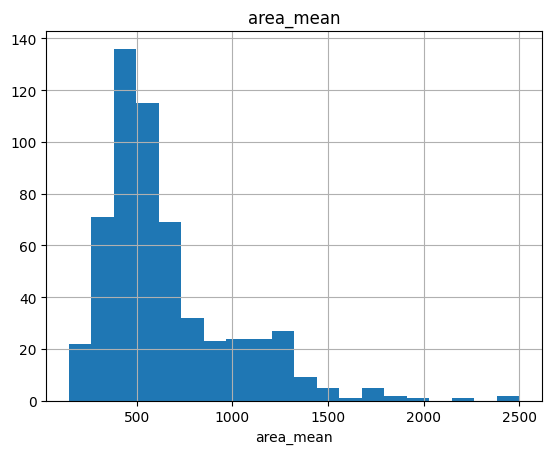

count    569.000000
mean       0.096360
std        0.014064
min        0.052630
5%         0.075042
10%        0.079654
20%        0.084206
30%        0.087914
40%        0.091828
50%        0.095870
60%        0.099338
70%        0.103260
80%        0.107500
90%        0.114820
95%        0.118780
99%        0.132888
max        0.163400
Name: smoothness_mean, dtype: float64


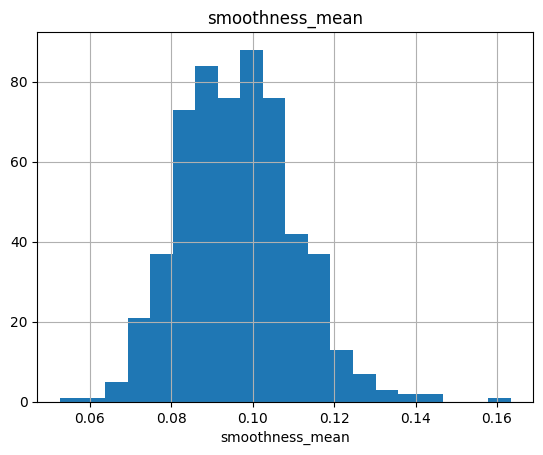

count    569.000000
mean       0.104341
std        0.052813
min        0.019380
5%         0.040660
10%        0.049700
20%        0.059638
30%        0.070390
40%        0.079530
50%        0.092630
60%        0.108740
70%        0.122420
80%        0.141900
90%        0.175460
95%        0.208700
99%        0.277192
max        0.345400
Name: compactness_mean, dtype: float64


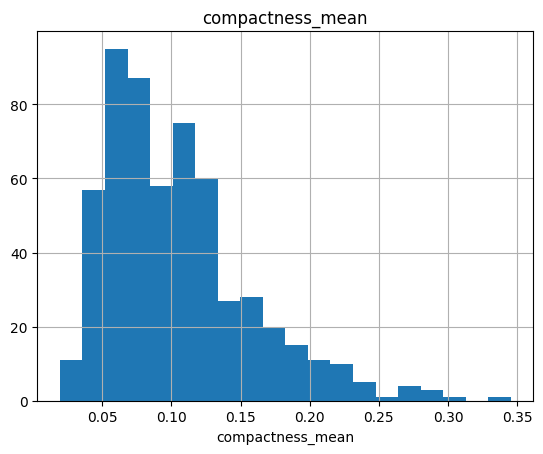

count    569.000000
mean       0.088799
std        0.079720
min        0.000000
5%         0.004983
10%        0.013686
20%        0.024930
30%        0.034400
40%        0.045070
50%        0.061540
60%        0.086212
70%        0.111920
80%        0.149780
90%        0.203040
95%        0.243020
99%        0.351688
max        0.426800
Name: concavity_mean, dtype: float64


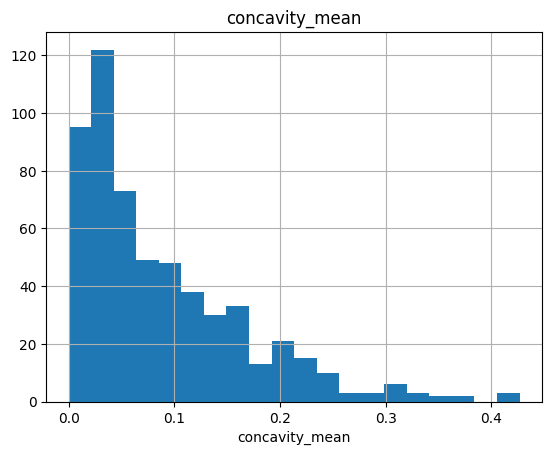

count    569.000000
mean       0.048919
std        0.038803
min        0.000000
5%         0.005621
10%        0.011158
20%        0.017866
30%        0.022788
40%        0.027982
50%        0.033500
60%        0.048318
70%        0.064496
80%        0.084254
90%        0.100420
95%        0.125740
99%        0.164208
max        0.201200
Name: concave points_mean, dtype: float64


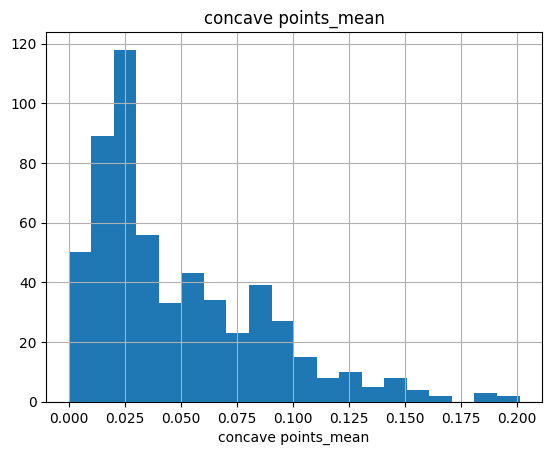

count    569.000000
mean       0.181162
std        0.027414
min        0.106000
5%         0.141500
10%        0.149580
20%        0.158760
30%        0.165080
40%        0.172000
50%        0.179200
60%        0.185480
70%        0.192800
80%        0.200540
90%        0.214940
95%        0.230720
99%        0.259564
max        0.304000
Name: symmetry_mean, dtype: float64


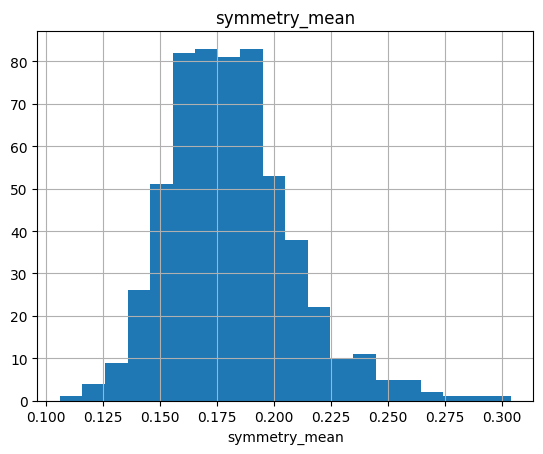

count    569.000000
mean       0.062798
std        0.007060
min        0.049960
5%         0.053926
10%        0.055338
20%        0.056864
30%        0.058840
40%        0.060204
50%        0.061540
60%        0.063148
70%        0.065048
80%        0.067630
90%        0.072266
95%        0.076090
99%        0.085438
max        0.097440
Name: fractal_dimension_mean, dtype: float64


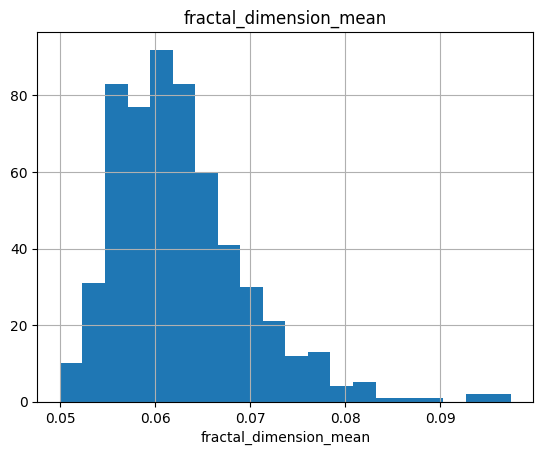

count    569.000000
mean       0.405172
std        0.277313
min        0.111500
5%         0.160100
10%        0.183080
20%        0.219280
30%        0.246040
40%        0.280200
50%        0.324200
60%        0.369460
70%        0.431020
80%        0.546140
90%        0.748880
95%        0.959520
99%        1.291320
max        2.873000
Name: radius_se, dtype: float64


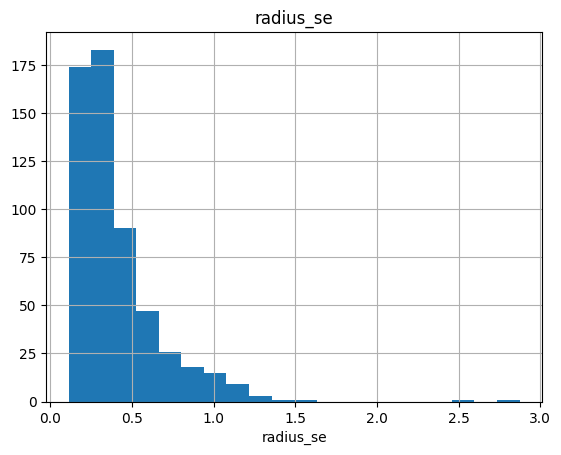

count    569.000000
mean       1.216853
std        0.551648
min        0.360200
5%         0.540140
10%        0.640400
20%        0.780600
30%        0.902100
40%        1.005200
50%        1.108000
60%        1.238800
70%        1.388200
80%        1.561200
90%        1.909400
95%        2.212000
99%        2.915440
max        4.885000
Name: texture_se, dtype: float64


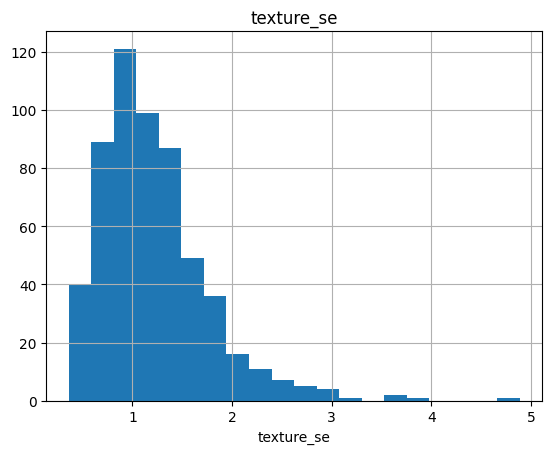

count    569.000000
mean       2.866059
std        2.021855
min        0.757000
5%         1.132800
10%        1.280200
20%        1.516600
30%        1.740800
40%        2.039400
50%        2.287000
60%        2.590800
70%        3.050200
80%        3.767800
90%        5.123200
95%        7.041600
99%        9.690040
max       21.980000
Name: perimeter_se, dtype: float64


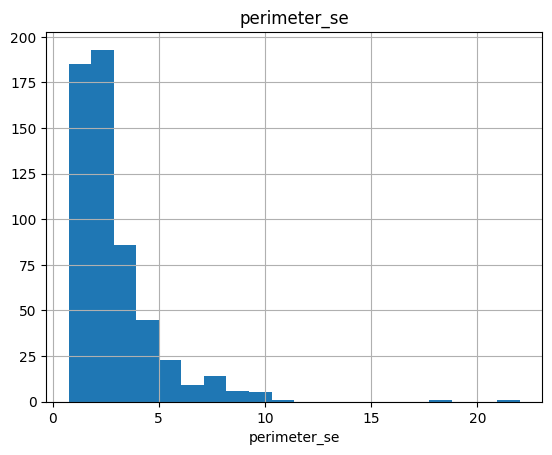

count    569.000000
mean      40.337079
std       45.491006
min        6.802000
5%        11.360000
10%       13.160000
20%       16.640000
30%       19.038000
40%       21.078000
50%       24.530000
60%       29.322000
70%       38.430000
80%       54.088000
90%       91.314000
95%      115.800000
99%      177.684000
max      542.200000
Name: area_se, dtype: float64


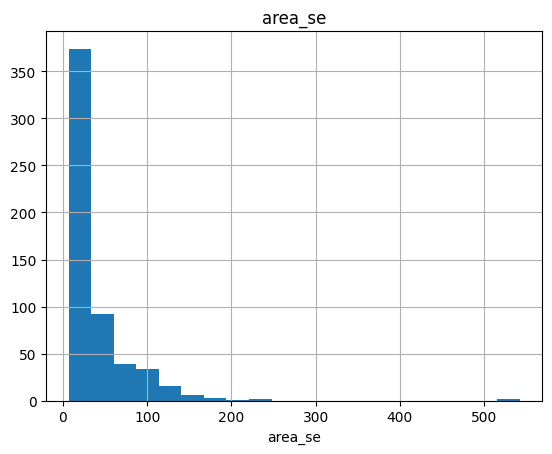

count    569.000000
mean       0.007041
std        0.003003
min        0.001713
5%         0.003690
10%        0.004224
20%        0.004871
30%        0.005417
40%        0.005843
50%        0.006380
60%        0.006944
70%        0.007773
80%        0.008828
90%        0.010410
95%        0.012644
99%        0.017258
max        0.031130
Name: smoothness_se, dtype: float64


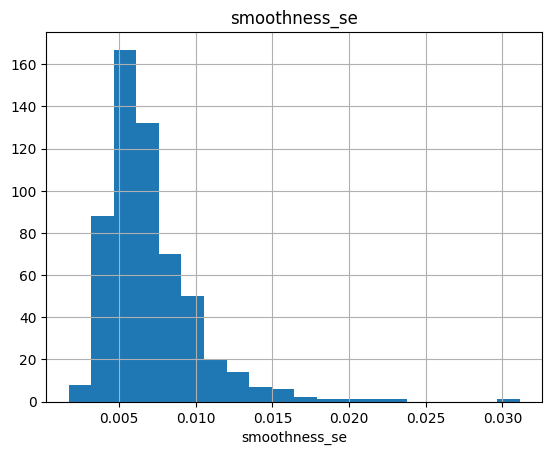

count    569.000000
mean       0.025478
std        0.017908
min        0.002252
5%         0.007892
10%        0.009169
20%        0.011800
30%        0.014240
40%        0.017020
50%        0.020450
60%        0.024480
70%        0.030136
80%        0.036198
90%        0.047602
95%        0.060578
99%        0.089872
max        0.135400
Name: compactness_se, dtype: float64


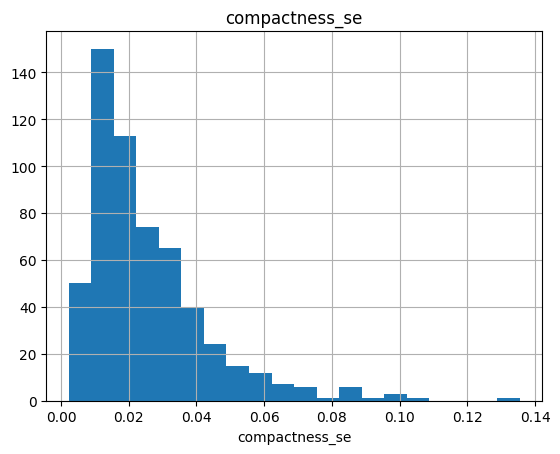

count    569.000000
mean       0.031894
std        0.030186
min        0.000000
5%         0.003253
10%        0.007726
20%        0.013212
30%        0.016980
40%        0.020456
50%        0.025890
60%        0.030544
70%        0.037362
80%        0.046404
90%        0.058520
95%        0.078936
99%        0.122292
max        0.396000
Name: concavity_se, dtype: float64


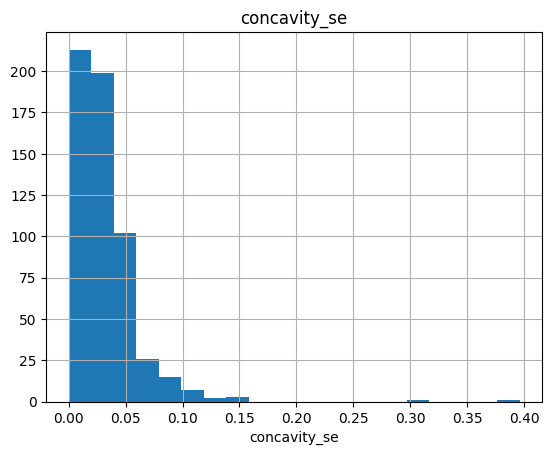

count    569.000000
mean       0.011796
std        0.006170
min        0.000000
5%         0.003831
10%        0.005493
20%        0.006893
30%        0.008465
40%        0.009617
50%        0.010930
60%        0.012410
70%        0.013700
80%        0.015812
90%        0.018688
95%        0.022884
99%        0.031194
max        0.052790
Name: concave points_se, dtype: float64


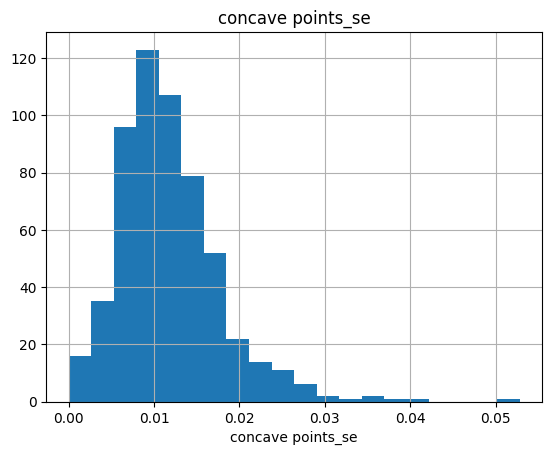

count    569.000000
mean       0.020542
std        0.008266
min        0.007882
5%         0.011758
10%        0.013012
20%        0.014540
30%        0.015704
40%        0.017170
50%        0.018730
60%        0.020066
70%        0.021978
80%        0.025680
90%        0.030120
95%        0.034988
99%        0.052208
max        0.078950
Name: symmetry_se, dtype: float64


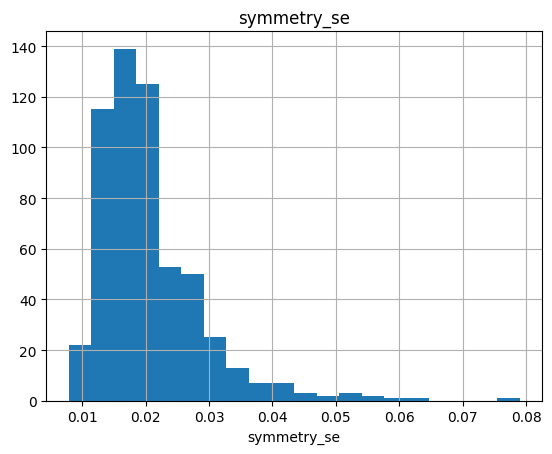

count    569.000000
mean       0.003795
std        0.002646
min        0.000895
5%         0.001522
10%        0.001710
20%        0.002057
30%        0.002382
40%        0.002752
50%        0.003187
60%        0.003611
70%        0.004172
80%        0.004830
90%        0.006185
95%        0.007960
99%        0.012650
max        0.029840
Name: fractal_dimension_se, dtype: float64


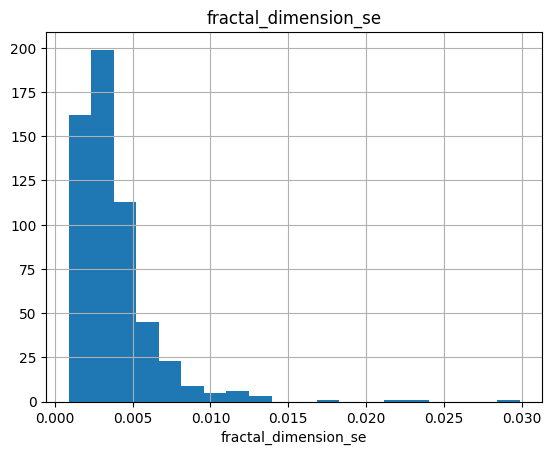

count    569.000000
mean      16.269190
std        4.833242
min        7.930000
5%        10.534000
10%       11.234000
20%       12.498000
30%       13.314000
40%       14.008000
50%       14.970000
60%       16.004000
70%       17.386000
80%       20.294000
90%       23.682000
95%       25.640000
99%       30.762800
max       36.040000
Name: radius_worst, dtype: float64


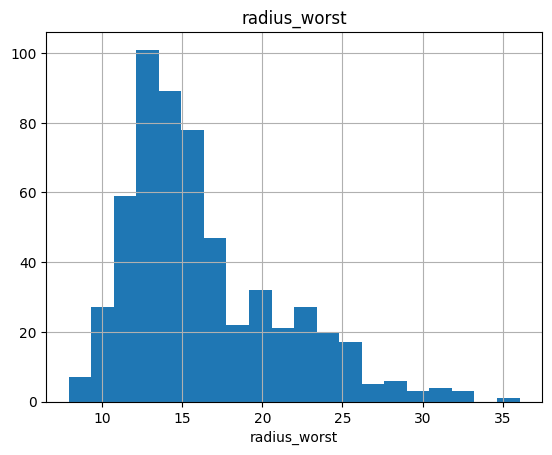

count    569.000000
mean      25.677223
std        6.146258
min       12.020000
5%        16.574000
10%       17.800000
20%       20.176000
30%       21.988000
40%       23.584000
50%       25.410000
60%       26.724000
70%       28.460000
80%       30.908000
90%       33.646000
95%       36.300000
99%       41.802400
max       49.540000
Name: texture_worst, dtype: float64


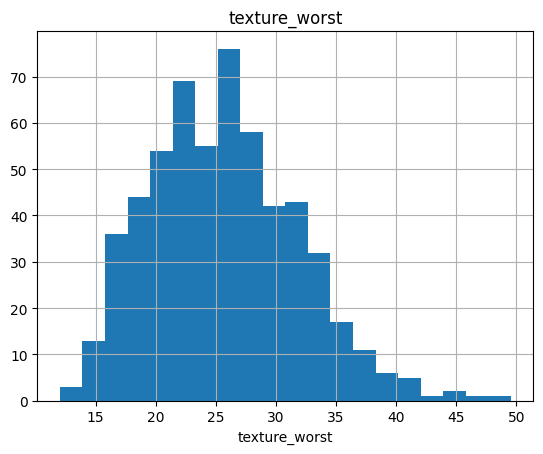

count    569.000000
mean     107.261213
std       33.602542
min       50.410000
5%        67.856000
10%       72.178000
20%       81.402000
30%       86.328000
40%       91.304000
50%       97.660000
60%      105.740000
70%      115.900000
80%      133.500000
90%      157.740000
95%      171.640000
99%      208.304000
max      251.200000
Name: perimeter_worst, dtype: float64


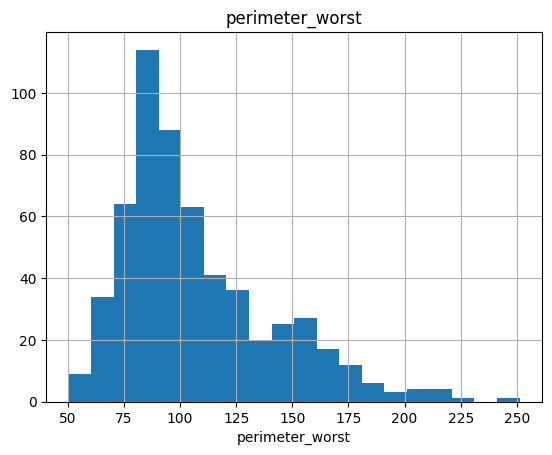

count     569.000000
mean      880.583128
std       569.356993
min       185.200000
5%        331.060000
10%       384.720000
20%       475.980000
30%       544.140000
40%       599.700000
50%       686.500000
60%       781.180000
70%       926.960000
80%      1269.000000
90%      1673.000000
95%      2009.600000
99%      2918.160000
max      4254.000000
Name: area_worst, dtype: float64


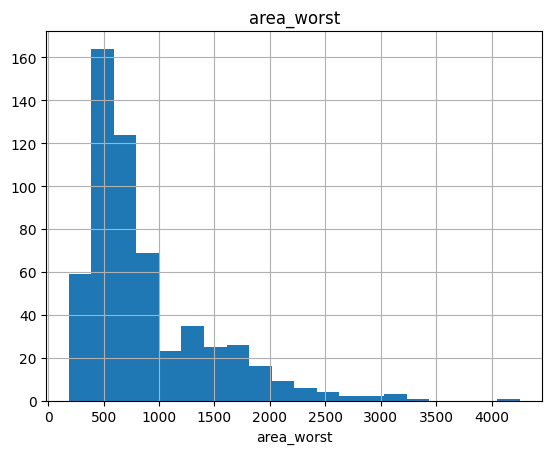

count    569.000000
mean       0.132369
std        0.022832
min        0.071170
5%         0.095734
10%        0.102960
20%        0.112520
30%        0.120740
40%        0.126320
50%        0.131300
60%        0.137680
70%        0.142600
80%        0.150080
90%        0.161480
95%        0.171840
99%        0.188908
max        0.222600
Name: smoothness_worst, dtype: float64


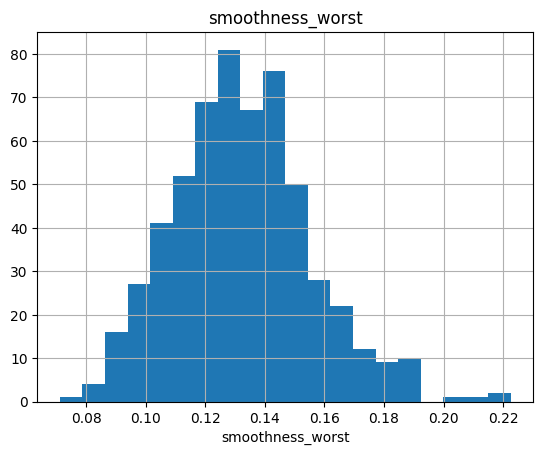

count    569.000000
mean       0.254265
std        0.157336
min        0.027290
5%         0.071196
10%        0.093676
20%        0.125660
30%        0.161400
40%        0.184620
50%        0.211900
60%        0.251400
70%        0.303960
80%        0.367060
90%        0.447840
95%        0.564120
99%        0.778644
max        1.058000
Name: compactness_worst, dtype: float64


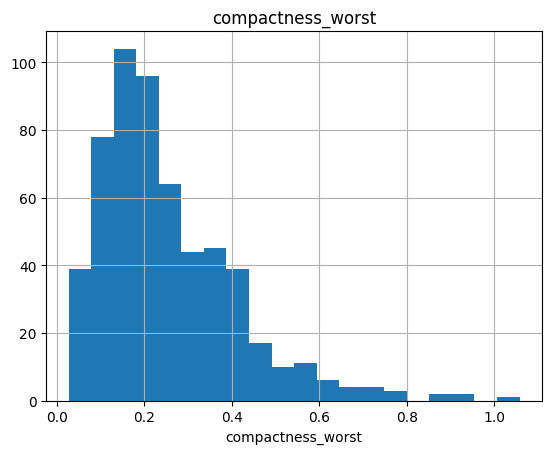

count    569.000000
mean       0.272188
std        0.208624
min        0.000000
5%         0.018360
10%        0.045652
20%        0.091974
30%        0.136880
40%        0.177180
50%        0.226700
60%        0.286600
70%        0.349920
80%        0.419540
90%        0.571320
95%        0.682380
99%        0.902380
max        1.252000
Name: concavity_worst, dtype: float64


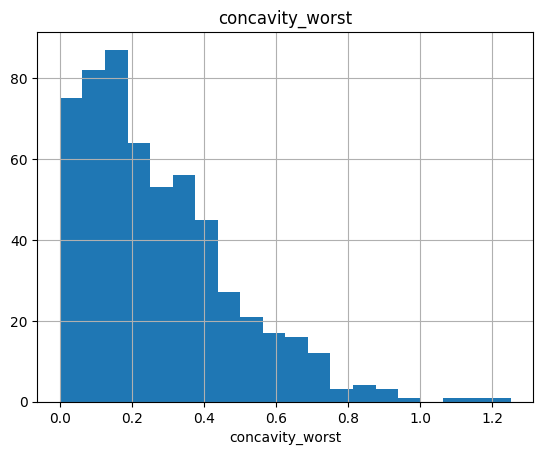

count    569.000000
mean       0.114606
std        0.065732
min        0.000000
5%         0.024286
10%        0.038460
20%        0.058086
30%        0.071656
40%        0.083914
50%        0.099930
60%        0.121800
70%        0.150800
80%        0.177540
90%        0.208940
95%        0.236920
99%        0.269216
max        0.291000
Name: concave points_worst, dtype: float64


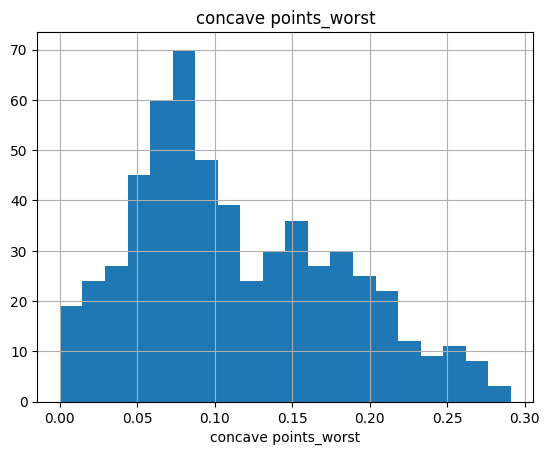

count    569.000000
mean       0.290076
std        0.061867
min        0.156500
5%         0.212700
10%        0.226120
20%        0.243620
30%        0.256520
40%        0.269400
50%        0.282200
60%        0.296480
70%        0.310220
80%        0.325380
90%        0.360080
95%        0.406160
99%        0.486908
max        0.663800
Name: symmetry_worst, dtype: float64


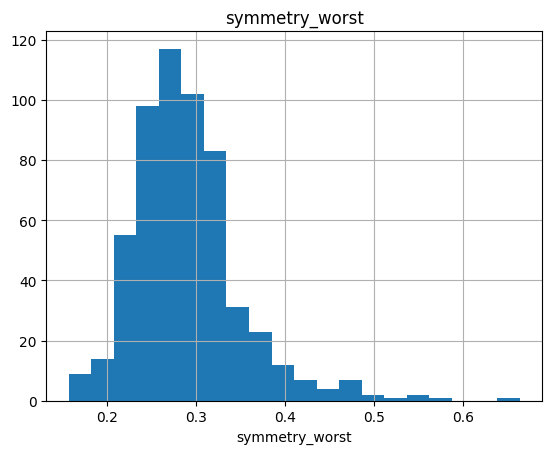

count    569.000000
mean       0.083946
std        0.018061
min        0.055040
5%         0.062558
10%        0.065792
20%        0.069654
30%        0.073462
40%        0.076852
50%        0.080040
60%        0.083202
70%        0.088984
80%        0.095934
90%        0.106320
95%        0.119520
99%        0.140628
max        0.207500
Name: fractal_dimension_worst, dtype: float64


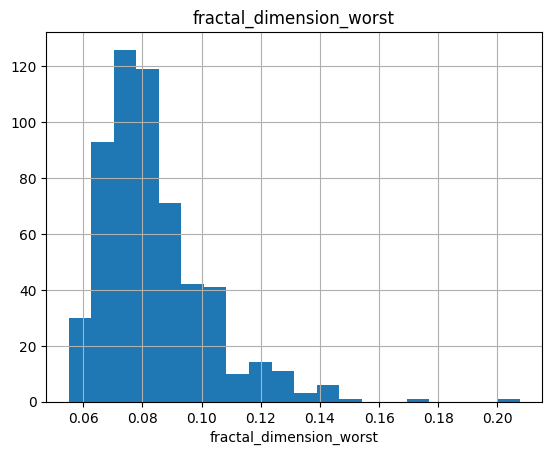

In [ ]:
#analyse numerical features
for col in num_cols:
    num_summary(df, col, plot=True)

In [ ]:
df = df.drop(['id'], axis=1) #cardinal
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

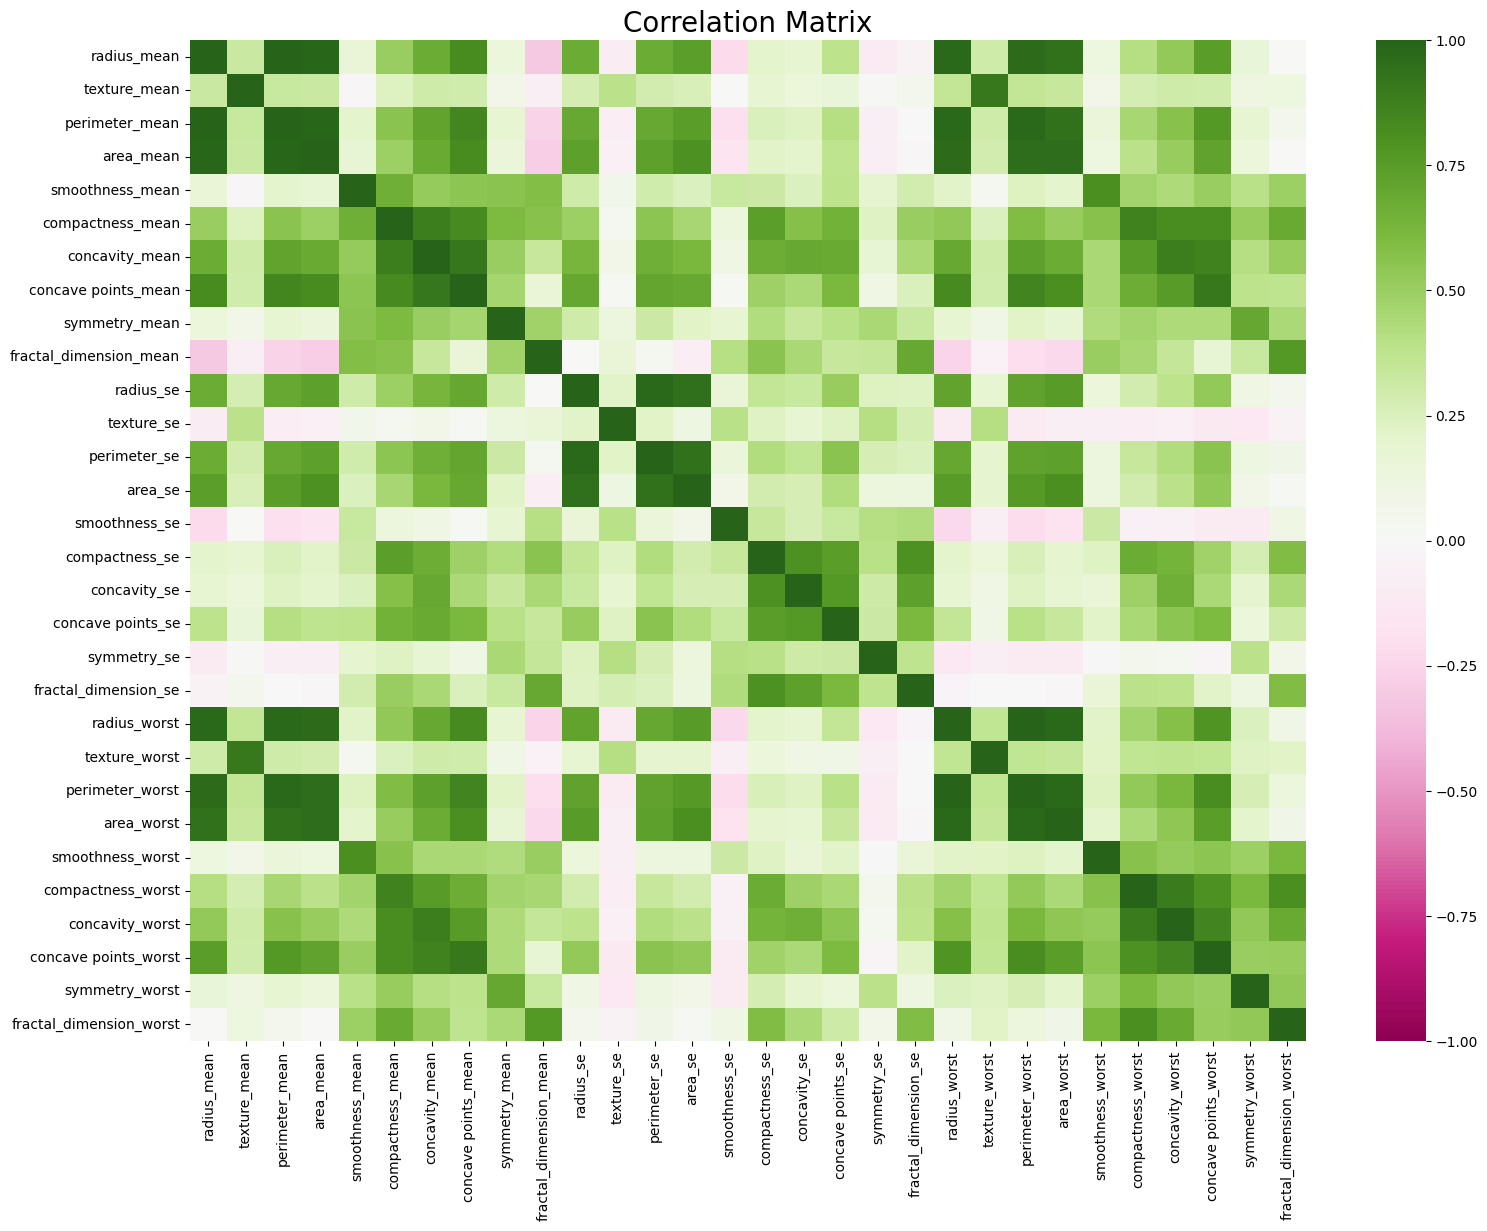

In [ ]:
# Correlation matrix
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), fmt=".2f", ax=ax, cmap='PiYG')
ax.collections[0].set_clim(-1,1)
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [ ]:
# analysis of target with numerical features
for col in num_cols:
    target_summary_with_num(df, "diagnosis", col)

           radius_mean
diagnosis             
B            12.146524
M            17.462830


           texture_mean
diagnosis              
B             17.914762
M             21.604906


           perimeter_mean
diagnosis                
B               78.075406
M              115.365377


            area_mean
diagnosis            
B          462.790196
M          978.376415


           smoothness_mean
diagnosis                 
B                 0.092478
M                 0.102898


           compactness_mean
diagnosis                  
B                  0.080085
M                  0.145188


           concavity_mean
diagnosis                
B                0.046058
M                0.160775


           concave points_mean
diagnosis                     
B                     0.025717
M                     0.087990


           symmetry_mean
diagnosis               
B               0.174186
M               0.192909


           fractal_dimension_mean
diagnosis           

#2. Data Preprocessing

In [ ]:
#define limits for outliers
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

#replace outliers with upper and lower thresholds
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# binary results to see which features have outliers
def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [ ]:
#catch cols with outliers
out_cols = []
for col in num_cols:
    if check_outlier(df, col):
        out_cols.append(col)
        print(col, True)
    else:
        print(col, False)

radius_mean False
texture_mean False
perimeter_mean False
area_mean False
smoothness_mean False
compactness_mean False
concavity_mean False
concave points_mean False
symmetry_mean False
fractal_dimension_mean False
radius_se True
texture_se True
perimeter_se True
area_se True
smoothness_se True
compactness_se False
concavity_se True
concave points_se True
symmetry_se True
fractal_dimension_se True
radius_worst False
texture_worst False
perimeter_worst False
area_worst False
smoothness_worst False
compactness_worst False
concavity_worst False
concave points_worst False
symmetry_worst False
fractal_dimension_worst True


In [ ]:
out_cols

['radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'fractal_dimension_worst']

In [ ]:
# a bit of trimming data
for col in out_cols:
  replace_with_thresholds(df, col)


In [ ]:
#Scale data before modelling
X_scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

#transform object type values of target to binary numeric
df["diagnosis"] = np.where(df["diagnosis"] == 'M',1,0)

#seperate target and predictive features
y = df["diagnosis"]
X = df.drop(["diagnosis"], axis=1)

#split df to seperate train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)

check_df(X_train)


##################### Shape #####################
(455, 30)
##################### Types #####################
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_wor

# 3. Base Models

In [ ]:
import warnings
warnings.simplefilter(action="ignore")


In [ ]:
#define multiple base models before hyperparamatization
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier(force_col_wise=True)),
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X_train, Y_train, scoring="accuracy")

Base Models....
accuracy: 0.9692 (LR) 
accuracy: 0.9648 (KNN) 
accuracy: 0.9758 (SVC) 
accuracy: 0.9274 (CART) 
accuracy: 0.9516 (RF) 
accuracy: 0.9626 (Adaboost) 
accuracy: 0.9538 (GBM) 
accuracy: 0.9626 (XGBoost) 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 113, number of negative: 190
[LightGBM] [Info] Total Bins 3027
[LightGBM] [Info] Number of data points in the train set: 303, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.372937 -> initscore=-0.519636
[LightGBM] [Info] Start training from score -0.519636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [ ]:
base_models(X_train, Y_train, scoring="precision")

Base Models....
precision: 0.9815 (LR) 
precision: 0.987 (KNN) 
precision: 0.9933 (SVC) 
precision: 0.8868 (CART) 
precision: 0.9523 (RF) 
precision: 0.9689 (Adaboost) 
precision: 0.941 (GBM) 
precision: 0.9586 (XGBoost) 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 113, number of negative: 190
[LightGBM] [Info] Total Bins 3027
[LightGBM] [Info] Number of data points in the train set: 303, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.372937 -> initscore=-0.519636
[LightGBM] [Info] Start training from score -0.519636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [ ]:
base_models(X_train, Y_train)

Base Models....
roc_auc: 0.9901 (LR) 
roc_auc: 0.9836 (KNN) 
roc_auc: 0.9939 (SVC) 
roc_auc: 0.9317 (CART) 
roc_auc: 0.9881 (RF) 
roc_auc: 0.9868 (Adaboost) 
roc_auc: 0.9869 (GBM) 
roc_auc: 0.9897 (XGBoost) 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 113, number of negative: 190
[LightGBM] [Info] Total Bins 3027
[LightGBM] [Info] Number of data points in the train set: 303, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.372937 -> initscore=-0.519636
[LightGBM] [Info] Start training from score -0.519636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

# 4. Hyperparameter Optimization

In [ ]:
knn_params = {"n_neighbors": range(2, 50)}

LR_params =  {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'max_iter' : [100, 1000, 2500, 5000]
    }

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [3, 5, 8],
                  "n_estimators": [50, 100, 200]}

SVC_params = {'C': np.logspace(-4, 4, 20), 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.001, 0.0001, 'scale', 'auto']}

AdaB_params = { 'n_estimators' : [40, 50, 70, 90, 120, 180, 200],
    'learning_rate' : [0.001, 0.01, 0.1, 1, 10]}


In [ ]:
classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("LR", LogisticRegression(), LR_params),
               ("SVC", SVC(), SVC_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('Adaboost', AdaBoostClassifier(), AdaB_params)]



def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

best_models = hyperparameter_optimization(X_train, Y_train, scoring="precision")

Hyperparameter Optimization....
########## KNN ##########
precision (Before): 0.987
precision (After): 0.987
KNN best params: {'n_neighbors': 5}

########## LR ##########
precision (Before): 0.9815
precision (After): 0.994
LR best params: {'C': 0.23357214690901212, 'max_iter': 100, 'penalty': 'l2'}

########## SVC ##########
precision (Before): 0.9933
precision (After): 0.9935
SVC best params: {'C': 1.623776739188721, 'gamma': 'scale', 'kernel': 'rbf'}

########## XGBoost ##########
precision (Before): 0.9586
precision (After): 0.9594
XGBoost best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

########## Adaboost ##########
precision (Before): 0.9689
precision (After): 0.9873
Adaboost best params: {'learning_rate': 1, 'n_estimators': 200}



Hyperparameter optimization slighlty improved the base models. Wider ranges applied to GridSearch may provide even better scores.

# 5. Model Evaluation

Final models evaluated by creating confusion matrix and several scores printed and checked as accuracy, precision, recall and f1 score.

In [ ]:
LR_final = LogisticRegression(C=0.23357214690901212, max_iter=100, penalty='l2').fit(X_train, Y_train)
SVC_final = SVC(C= 1.623776739188721, gamma= 'scale', kernel= 'rbf').fit(X_train, Y_train)
knn_final = KNeighborsClassifier(n_neighbors=5).fit(X_train, Y_train)
AdaB_final = AdaBoostClassifier(learning_rate = 1, n_estimators = 200).fit(X_train, Y_train)
XGB_final = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
learning_rate = 0.1, max_depth = 3, n_estimators = 100).fit(X_train, Y_train)

In [ ]:
def cmx(classifier):
  y_predicted = classifier.predict(X_test)
  print(classification_report(Y_test,y_predicted))
  cm = confusion_matrix(Y_test, y_predicted)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title(f"confusion matrix {classifier}")
  plt.show()



              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



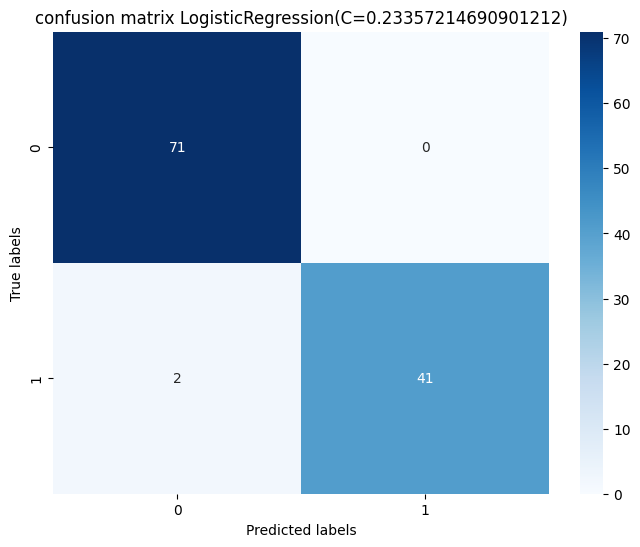

In [ ]:
cmx(LR_final)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



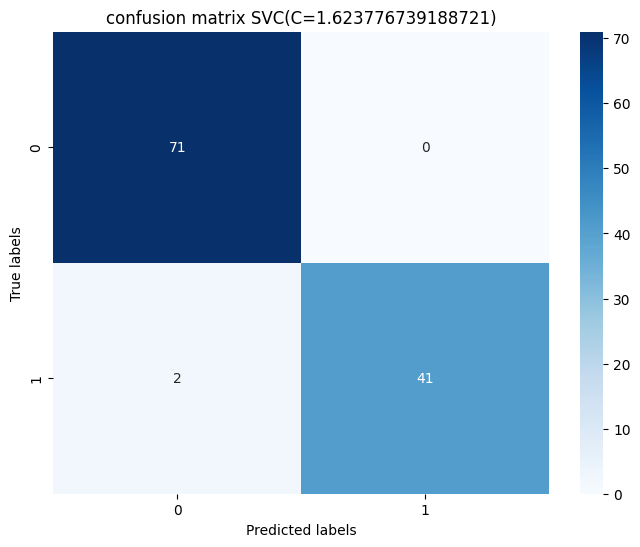

In [ ]:
cmx(SVC_final)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



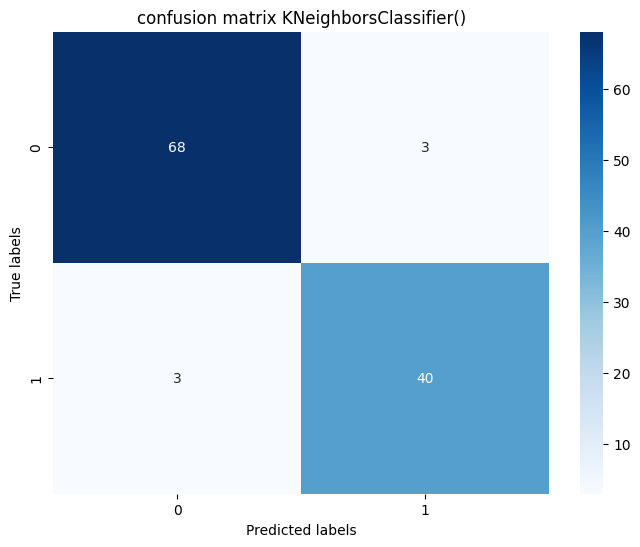

In [ ]:
cmx(knn_final)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



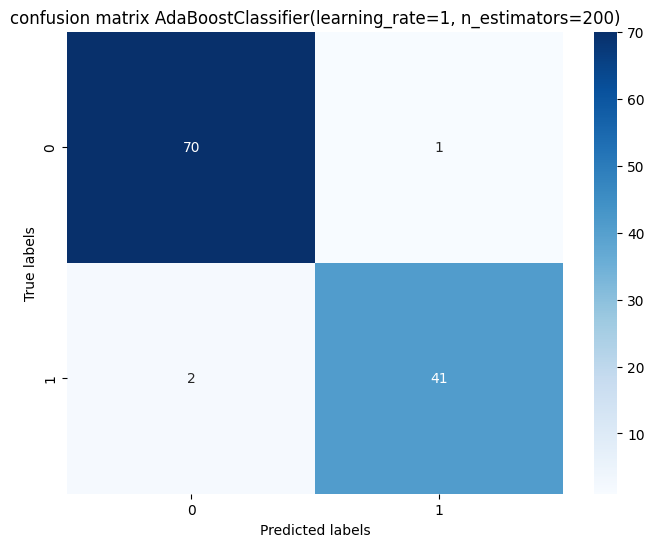

In [ ]:
cmx(AdaB_final)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



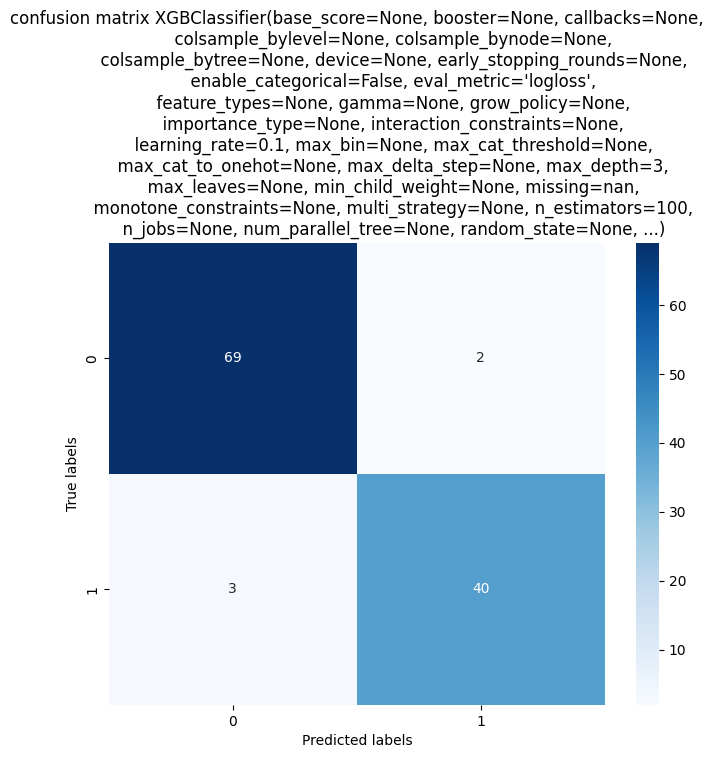

In [ ]:
cmx(XGB_final)

After the model evaluation, Logistic Regression and Support vector machines class SVC were better performing models compared to AdaBoost, XGBoost or KNN.